In [17]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import load_boston
from sklearn.preprocessing import StandardScaler
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RationalQuadratic, Matern

from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score

from sklearn.metrics import r2_score

# user variables to tune
folds   = 10
scaler = StandardScaler()

In [15]:
def predict(data,values,test,true,clf):
    train = clf.fit(data,values)
    pred = clf.predict(test)
    df = pd.DataFrame(data=[pred,true])
    
    return pred,train,df

def plot_model(pred,true):
    plt.figure(figsize=(18, 6))

    plt.plot(pred, color='b') #Pred
    plt.plot(true, color='r') #True
    plt.show()

In [3]:
pd.options.display.float_format = '{:,.2f}'.format

dataset = load_boston()
df = pd.DataFrame(dataset.data)
df.columns = dataset.feature_names
df["PRICE"] = dataset.target

X = df.drop("PRICE", axis=1)
Y = df["PRICE"]
print(X.shape)
print(Y.shape)

(506, 13)
(506,)


In [6]:
X.head()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT
0,0.01,18.00,2.31,0.00,0.54,6.58,65.20,4.09,1.00,296.00,15.30,396.90,4.98
1,0.03,0.00,7.07,0.00,0.47,6.42,78.90,4.97,2.00,242.00,17.80,396.90,9.14
2,0.03,0.00,7.07,0.00,0.47,7.18,61.10,4.97,2.00,242.00,17.80,392.83,4.03
3,0.03,0.00,2.18,0.00,0.46,7.00,45.80,6.06,3.00,222.00,18.70,394.63,2.94
4,0.07,0.00,2.18,0.00,0.46,7.15,54.20,6.06,3.00,222.00,18.70,396.90,5.33


In [4]:
scaler.fit(X.values)
scaled_X = scaler.transform(X.values)

In [35]:
seed = 1000
test_size = 0.20

X_train, X_test, Y_train, Y_test = train_test_split(scaled_X, Y, test_size = test_size, random_state = seed)

print(X_train.shape)
print(X_test.shape)
print(Y_train.shape)
print(Y_test.shape)

(404, 13)
(102, 13)
(404,)
(102,)


In [36]:
kernel = RationalQuadratic()

In [37]:
models = GaussianProcessRegressor(kernel)
# models = GaussianProcessRegressor()

In [38]:
pred,trained,df1 = predict(X_train, Y_train, X_test, Y_test, models)

In [39]:
display(df1)
print(models.score(scaled_X, Y))

,0,1,2,3,4,5,6,7,8,9,...,92,93,94,95,96,97,98,99,100,101
0,21.62,16.15,16.42,39.70,22.65,32.84,12.85,39.26,18.55,16.43,...,25.00,11.92,25.03,21.70,19.97,24.77,20.52,20.72,20.27,20.54
1,21.80,10.20,15.20,43.50,50.00,37.20,7.00,42.30,16.00,19.60,...,24.80,12.30,24.60,24.30,19.00,22.00,20.00,19.90,19.10,21.20


0.959549941399


In [14]:
# 10-fold cross validation for each model

k_fold  = KFold(n_splits=folds, random_state=seed)
results = cross_val_score(models, X_train, Y_train, cv=k_fold, scoring='r2')

print("r2:\t",results.mean(),"\nstd:\t",results.std())

r2:	 0.818888131057 
std:	 0.0987231047755


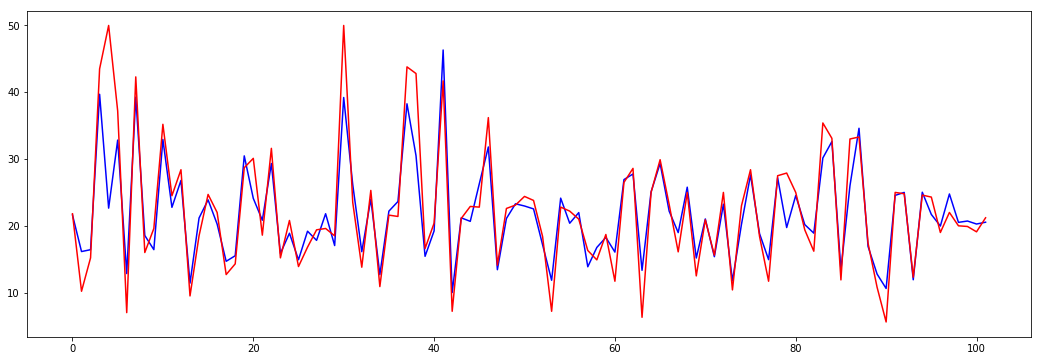

In [45]:
plot_model(pred,Y_test.to_list())

In [ ]:
# Imports
import sys
import numpy as np
import pandas as pd
import tensorflow as tf
import tensorflow_probability as tfp

import bokeh
import bokeh.io
import bokeh.plotting
import bokeh.models
from IPython.display import display, HTML
bokeh.io.output_notebook(hide_banner=True)

tfd = tfp.distributions
psd_kernels = tfp.positive_semidefinite_kernels

np.random.seed(42)
tf.set_random_seed(42)
#

ImportError: DLL load failed: The specified module could not be found.

SystemError: <class '_frozen_importlib._ModuleLockManager'> returned a result with an error set

ImportError: numpy.core._multiarray_umath failed to import

ImportError: numpy.core.umath failed to import

<IPython.core.display.Javascript object>


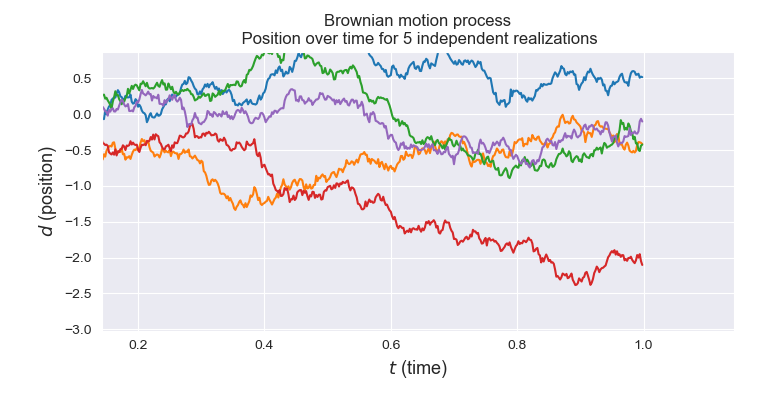

In [3]:
# 1D simulation of the Brownian motion process
total_time = 1
nb_steps = 500
delta_t = total_time / nb_steps
nb_processes = 5  # Simulate 5 different motions
mean = 0.  # Mean of each movement
stdev = np.sqrt(delta_t)  # Standard deviation of each movement

# Simulate the brownian motions in a 1D space by cumulatively
#  making a new movement delta_d
distances = np.cumsum(
    # Move randomly from current location to N(0, delta_t)
    np.random.normal(
        mean, stdev, (nb_processes, nb_steps)),
    axis=1)

plt.figure(figsize=(6, 4))
# Make the plots
t = np.arange(0, total_time, delta_t)
for i in range(nb_processes):
    plt.plot(t, distances[i,:])
plt.title((
    'Brownian motion process\n '
    'Position over time for 5 independent realizations'))
plt.xlabel('$t$ (time)', fontsize=13)
plt.ylabel('$d$ (position)', fontsize=13)
plt.xlim([-0, 1])
plt.tight_layout()
plt.show()
#

In [4]:
# Define the exponentiated quadratic 
def exponentiated_quadratic(xa, xb):
    """Exponentiated quadratic  with σ=1"""
    # L2 distance (Squared Euclidian)
    sq_norm = -0.5 * scipy.spatial.distance.cdist(xa, xb, 'sqeuclidean')
    return np.exp(sq_norm)

<IPython.core.display.Javascript object>


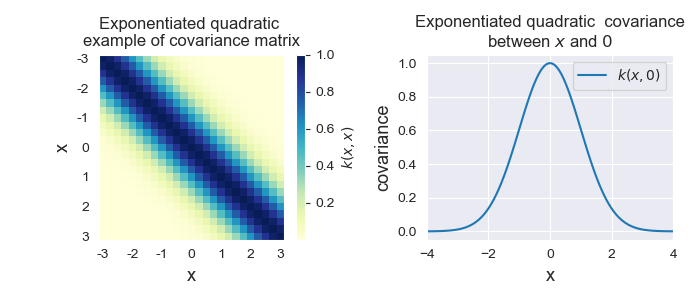

In [5]:
# Illustrate covariance matrix and function

# Show covariance matrix example from exponentiated quadratic
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(7, 3))
xlim = (-3, 3)
X = np.expand_dims(np.linspace(*xlim, 25), 1)
Σ = exponentiated_quadratic(X, X)
# Plot covariance matrix
im = ax1.imshow(Σ, cmap=cm.YlGnBu)
cbar = plt.colorbar(
    im, ax=ax1, fraction=0.045, pad=0.05)
cbar.ax.set_ylabel('$k(x,x)$', fontsize=10)
ax1.set_title((
    'Exponentiated quadratic \n'
    'example of covariance matrix'))
ax1.set_xlabel('x', fontsize=13)
ax1.set_ylabel('x', fontsize=13)
ticks = list(range(xlim[0], xlim[1]+1))
ax1.set_xticks(np.linspace(0, len(X)-1, len(ticks)))
ax1.set_yticks(np.linspace(0, len(X)-1, len(ticks)))
ax1.set_xticklabels(ticks)
ax1.set_yticklabels(ticks)
ax1.grid(False)

# Show covariance with X=0
xlim = (-4, 4)
X = np.expand_dims(np.linspace(*xlim, num=100), 1)
zero = np.array([[0]])
Σ0 = exponentiated_quadratic(X, zero)
# Make the plots
ax2.plot(X[:,0], Σ0[:,0], label='$k(x,0)$')
ax2.set_xlabel('x', fontsize=13)
ax2.set_ylabel('covariance', fontsize=13)
ax2.set_title((
    'Exponentiated quadratic  covariance\n'
    'between $x$ and $0$'))
# ax2.set_ylim([0, 1.1])
ax2.set_xlim(*xlim)
ax2.legend(loc=1)

fig.tight_layout()
plt.show()
#